In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib as mlp
import MultiLayerDQTF as dq
from sklearn.datasets import make_regression
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error
from tqdm.notebook import tqdm
from scipy.stats import norm
import importlib as il

# Model expectation and uncertainty

In [2]:
def pred_ints(model,X_list):
    est_num = len(model.estimators_)
    preds = np.zeros((est_num,len(X_list)))
    for i,pred in enumerate(model.estimators_):
        preds[i] = pred.predict(X_list)

    means = np.mean(preds,axis=0)
    std = np.std(preds,axis=0)
    return means, std

# Metrics typically used on heuristics

In [3]:
def FunRandom(x,model,fstar):
    return np.random.uniform(size=len(x))

def Greedy(x_list,model,fstar):
    return model.predict(x_list)

def UCB(x_list,model,fstar,beta=2):
    mu,sigma = pred_ints(model,x_list)
    return mu+beta*sigma

def gamma(x_list,model,fstar,epsilon=0.01):
    return model.predict(x_list)-fstar+epsilon

def z(x_list,model,fstar):
    mu, sigma = pred_ints(model,x_list)
    return gamma(x_list,model,fstar)/sigma

def EI(x_list,model, fstar):
    mu, sigma = pred_ints(model,x_list)
    zl = z(x_list,model,fstar)
    eis = np.zeros_like(mu)
    gl = gamma(x_list,model,fstar)
    for i,gam,zz,ss in zip(list(range(len(mu))),gl,zl,sigma):
        if(ss>0):
            eis[i] = gam*norm.cdf(zz)+ss*norm.pdf(zz)
        else:
            eis[i] = gam
    return eis
    
def PI(x_list,model,fstar):
    mu,sigma = pred_ints(model,x_list)
    zl = z(x_list,model,fstar)
    gam = gamma(x_list,model,fstar)
    ppi = np.zeros_like(mu)
    for i,gg,ss,zz in zip(list(range(len(x_list))),gam,sigma,zl):
        if(ss>0):
            ppi[i] = norm.cdf(zz)
        else:
            if(gg>0):
                ppi[i]=1
            else:
                ppi[i]=0
    return ppi

# Obtain the simulated data set

In [4]:
seeds = [658, 682]
NUMBER_SAMPLES = 5000
X_train, y_train = make_regression(n_samples=NUMBER_SAMPLES,n_features=10,n_informative=5,n_targets=1,noise=0.0)
fstar = np.percentile(y_train,90)
NEP = 30
BUDGET = 100
BATCH_SIZE = 35

In [5]:
# Greedy sampling function on feature space (just distance to nearest neighboor)
def GS_x(x,x_list):
    distances = np.zeros_like(x_list)

    for ii,xx in enumerate(x_list):
        distances[ii] = np.sqrt(np.sum((x-xx)**2))
    
    return np.min(distances)

def GS_y(x,y_init,model):
    Ypreds = model.predict([x])
    distances =  np.zeros_like(y_init)
    for ii, xx in enumerate(y_init):
        distances[ii] = np.abs(Ypreds-xx)
    return np.min(distances)

def state(model,cand,pool_xs,pool_vals):
    gsx = GS_x(cand,pool_xs)
    gsy = GS_y(cand,pool_vals,model)
    return tf.cast(np.array([[*cand,gsx,gsy]]).reshape(1,-1),dtype=tf.float32)

def state_her(model,cand,fstar):
    pred, uncert = pred_ints(model,[cand])
    Pi_v = PI([cand],model,fstar)
    UCB_v = UCB([cand],model,fstar,beta=2)
    return tf.cast(np.array([*cand,*pred,*uncert,*Pi_v,*UCB_v]).reshape(1,-1),dtype=tf.float32)


## Two layer deep learning policy maker

In [6]:
il.reload(dq)

<module 'MultiLayerDQTF' from '/Users/tingua/Documents/2023 Spring/Merck 2023 Spring/MultiLayerDQTF.py'>

In [7]:
x_o, y_o = X_train[:100], y_train[:100]
x_held, y_held = X_train[100:200], y_train[100:200]
x_candidates, y_candidates = X_train[200:], y_train[200:]

In [8]:
model1 = dq.Qlearner(12,[256,256],2,alpha=1e-3)
aprox_perf = []

Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2023-03-23 12:46:20.089266: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-03-23 12:46:20.090084: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [9]:
for seed in tqdm(range(NEP),desc='Episode'):
    aprox_perf.append([])
    randomizer = np.random
    indices = list(range(NUMBER_SAMPLES-200))
    randomizer.shuffle(indices)
    x_init, y_init = x_o.copy(), y_o.copy() #tf.cast(X_train[indices[:100]],dtype=tf.float32), tf.cast(y_train[indices[:100]],dtype=tf.float32)
    x_cand, y_cand = x_candidates[indices], y_candidates[indices] #tf.cast(X_train[indices[200:]],dtype=tf.float32), tf.cast(y_train[indices[200:]],dtype=tf.float32)
    initial_model = RandomForestRegressor(100, n_jobs=-2,random_state=158)
    initial_model.fit(x_init,y_init)
    usd = 0 
    error_prev = mean_squared_error(y_held,initial_model.predict(x_held))
    for i in tqdm(range(200),desc='State Looping'):
        s_i = state(initial_model,x_cand[i],x_init,y_init)
        a_i = tf.argmax(tf.transpose(model1.compute_qvalue(s_i)))
        if(a_i==1):
            x_init = np.append(x_init,[x_cand[i]],0)
            y_init = np.append(y_init,[y_cand[i]],0)
            usd += 1
            initial_model.fit(x_init,y_init)
            aprox_perf[-1].append(mean_squared_error(y_held,initial_model.predict(x_held)))
        error_current = mean_squared_error(y_held,initial_model.predict(x_held))
        reward = error_prev-error_current
        error_prev = error_current
        if(usd==BUDGET or i==199):
            model1.add_to_memory(s_i,a_i,reward,None)
            break
        else:
            s_ip1 = state(initial_model,x_cand[i+1],x_init,y_init)
            model1.add_to_memory(s_i,a_i,reward,s_ip1)

        if(i>BATCH_SIZE):
            cur_mem = model1.get_current_memory()
            indices = randomizer.randint(len(cur_mem)-1,size=BATCH_SIZE)
            batch_sf = tf.reshape(tf.cast(list( cur_mem[i][3] for i in indices),dtype=tf.float32),[BATCH_SIZE,12])
            batch_r = tf.reshape(tf.cast(list( cur_mem[i][2] for i in indices),dtype=tf.float32),[BATCH_SIZE,1])
            batch_si = tf.reshape(tf.cast(list( cur_mem[i][0] for i in indices),dtype=tf.float32),[BATCH_SIZE,12])
            batch_ai = tf.reshape(tf.cast(list( cur_mem[i][1] for i in indices),dtype=tf.float32),[BATCH_SIZE,1])
            ys = model1.y_value(batch_sf,batch_r )
            model1.Training_network(ys,batch_ai,batch_si)
    model1.finish_episode()

Episode:   0%|          | 0/30 [00:00<?, ?it/s]

State Looping:   0%|          | 0/200 [00:00<?, ?it/s]

2023-03-23 12:46:27.900630: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-03-23 12:46:27.908588: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-03-23 12:46:28.052734: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-03-23 12:46:28.088984: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-03-23 12:46:28.282439: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


State Looping:   0%|          | 0/200 [00:00<?, ?it/s]

State Looping:   0%|          | 0/200 [00:00<?, ?it/s]

State Looping:   0%|          | 0/200 [00:00<?, ?it/s]

State Looping:   0%|          | 0/200 [00:00<?, ?it/s]

State Looping:   0%|          | 0/200 [00:00<?, ?it/s]

State Looping:   0%|          | 0/200 [00:00<?, ?it/s]

State Looping:   0%|          | 0/200 [00:00<?, ?it/s]

State Looping:   0%|          | 0/200 [00:00<?, ?it/s]

State Looping:   0%|          | 0/200 [00:00<?, ?it/s]

State Looping:   0%|          | 0/200 [00:00<?, ?it/s]

State Looping:   0%|          | 0/200 [00:00<?, ?it/s]

State Looping:   0%|          | 0/200 [00:00<?, ?it/s]

State Looping:   0%|          | 0/200 [00:00<?, ?it/s]

State Looping:   0%|          | 0/200 [00:00<?, ?it/s]

State Looping:   0%|          | 0/200 [00:00<?, ?it/s]

State Looping:   0%|          | 0/200 [00:00<?, ?it/s]

State Looping:   0%|          | 0/200 [00:00<?, ?it/s]

State Looping:   0%|          | 0/200 [00:00<?, ?it/s]

State Looping:   0%|          | 0/200 [00:00<?, ?it/s]

State Looping:   0%|          | 0/200 [00:00<?, ?it/s]

State Looping:   0%|          | 0/200 [00:00<?, ?it/s]

State Looping:   0%|          | 0/200 [00:00<?, ?it/s]

State Looping:   0%|          | 0/200 [00:00<?, ?it/s]

State Looping:   0%|          | 0/200 [00:00<?, ?it/s]

State Looping:   0%|          | 0/200 [00:00<?, ?it/s]

State Looping:   0%|          | 0/200 [00:00<?, ?it/s]

State Looping:   0%|          | 0/200 [00:00<?, ?it/s]

State Looping:   0%|          | 0/200 [00:00<?, ?it/s]

State Looping:   0%|          | 0/200 [00:00<?, ?it/s]

Text(0.5, 0, 'Number of candidate points added')

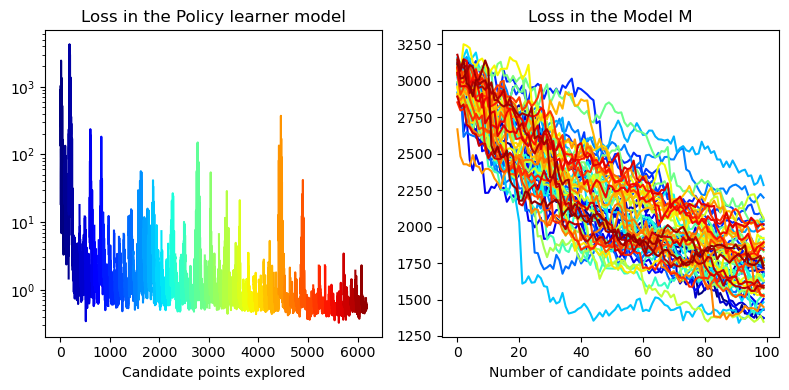

In [19]:
fig, ax = plt.subplots(1,2,tight_layout=True,figsize=(8,4))
l_old = 0
for i in range(len(model1.loss_curve)-1):
    ll = model1.loss_curve[i]
    ax[0].plot(range(l_old,l_old+len(ll)),ll,'-',label='Episode %i'%i,c=plt.cm.jet(i/model1.current_episode))
    l_old += len(ll) 
#ax[0].legend(loc=0)
ax[0].set_yscale('log')

for i in range(model1.current_episode):
    ax[1].plot(aprox_perf[i],c=plt.cm.jet(i/model1.current_episode))

ax[0].set_title('Loss in the Policy learner model')
ax[0].set_xlabel("Candidate points explored")
ax[1].set_title("Loss in the Model M")
ax[1].set_xlabel("Number of candidate points added")

Text(0.5, 0.01, 'Episodes of policy training')

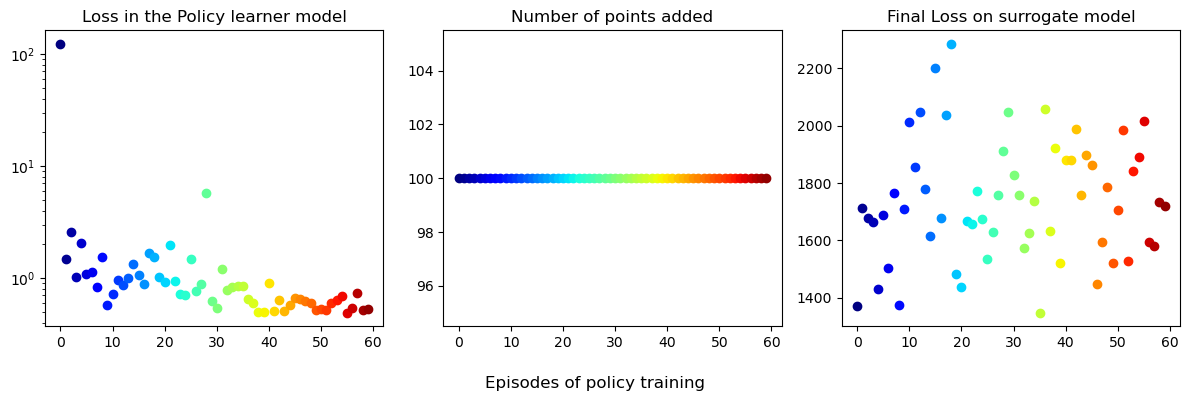

In [20]:
fig, ax = plt.subplots(1,3,tight_layout=True,figsize=(12,4))
l_old = 0
for i in range(model1.current_episode):
    ax[0].plot(i,model1.loss_curve[i][-1],'o',label='Episode %i'%i,c=plt.cm.jet(i/model1.current_episode))
#ax[0].legend(loc=0)
ax[0].set_yscale('log')

for i in range(model1.current_episode):
    ax[1].plot(i,len(aprox_perf[i]),'o',c=plt.cm.jet(i/model1.current_episode))

for i in range(model1.current_episode):
    ax[2].plot(i,aprox_perf[i][-1],'o',c=plt.cm.jet(i/model1.current_episode))

ax[0].set_title('Loss in the Policy learner model')
ax[1].set_title("Loss in the Model M")
ax[1].set_title("Number of points added")
ax[2].set_title('Final Loss on surrogate model')
fig.supxlabel('Episodes of policy training')

In [12]:
for seed in tqdm(range(5),desc='Episode'):
    aprox_perf.append([])
    randomizer = np.random
    indices = list(range(NUMBER_SAMPLES-200))
    randomizer.shuffle(indices)
    x_init, y_init = x_o.copy(), y_o.copy() #tf.cast(X_train[indices[:100]],dtype=tf.float32), tf.cast(y_train[indices[:100]],dtype=tf.float32)
    x_cand, y_cand = x_candidates[indices], y_candidates[indices] #tf.cast(X_train[indices[200:]],dtype=tf.float32), tf.cast(y_train[indices[200:]],dtype=tf.float32)
    initial_model = RandomForestRegressor(100, n_jobs=-2,random_state=158)
    initial_model.fit(x_init,y_init)
    usd = 0 
    error_prev = mean_squared_error(y_held,initial_model.predict(x_held))
    for i in tqdm(range(200),desc='State Looping'):
        s_i = state(initial_model,x_cand[i],x_init,y_init)
        a_i = tf.argmax(tf.transpose(model1.compute_qvalue(s_i)))
        if(a_i==1):
            x_init = np.append(x_init,[x_cand[i]],0)
            y_init = np.append(y_init,[y_cand[i]],0)
            usd += 1
            initial_model.fit(x_init,y_init)
            aprox_perf[-1].append(mean_squared_error(y_held,initial_model.predict(x_held)))
        error_current = mean_squared_error(y_held,initial_model.predict(x_held))
        reward = error_prev-error_current
        error_prev = error_current
        if(usd==BUDGET or i==199):
            model1.add_to_memory(s_i,a_i,reward,None)
            break
        else:
            s_ip1 = state(initial_model,x_cand[i+1],x_init,y_init)
            model1.add_to_memory(s_i,a_i,reward,s_ip1)

        if(i>BATCH_SIZE):
            cur_mem = model1.get_current_memory()
            indices = randomizer.randint(len(cur_mem)-1,size=BATCH_SIZE)
            batch_sf = tf.reshape(tf.cast(list( cur_mem[i][3] for i in indices),dtype=tf.float32),[BATCH_SIZE,12])
            batch_r = tf.reshape(tf.cast(list( cur_mem[i][2] for i in indices),dtype=tf.float32),[BATCH_SIZE,1])
            batch_si = tf.reshape(tf.cast(list( cur_mem[i][0] for i in indices),dtype=tf.float32),[BATCH_SIZE,12])
            batch_ai = tf.reshape(tf.cast(list( cur_mem[i][1] for i in indices),dtype=tf.float32),[BATCH_SIZE,1])
            ys = model1.y_value(batch_sf,batch_r )
            model1.Training_network(ys,batch_ai,batch_si)
    model1.finish_episode()

Episode:   0%|          | 0/5 [00:00<?, ?it/s]

State Looping:   0%|          | 0/200 [00:00<?, ?it/s]

State Looping:   0%|          | 0/200 [00:00<?, ?it/s]

State Looping:   0%|          | 0/200 [00:00<?, ?it/s]

State Looping:   0%|          | 0/200 [00:00<?, ?it/s]

State Looping:   0%|          | 0/200 [00:00<?, ?it/s]

Text(0.5, 0.01, 'Episodes of policy training')

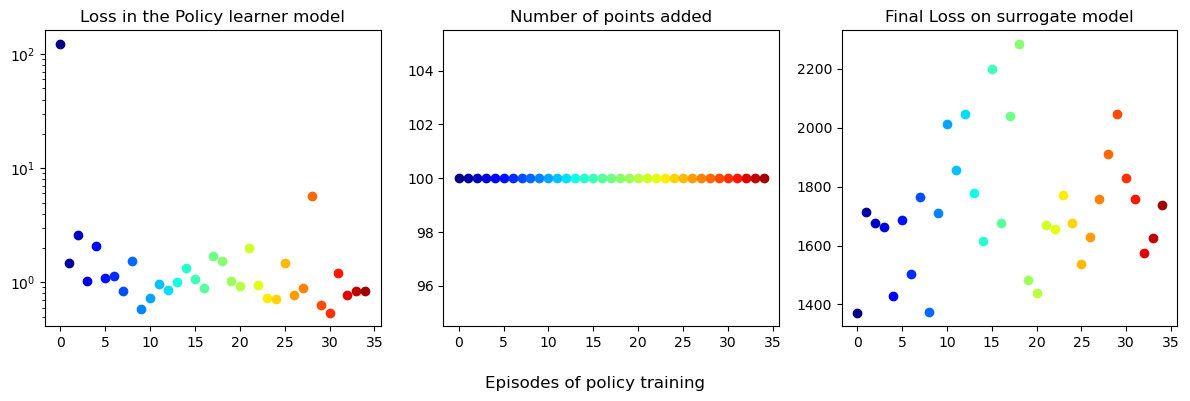

In [13]:
fig, ax = plt.subplots(1,3,tight_layout=True,figsize=(12,4))
l_old = 0
for i in range(model1.current_episode):
    ax[0].plot(i,model1.loss_curve[i][-1],'o',label='Episode %i'%i,c=plt.cm.jet(i/model1.current_episode))
#ax[0].legend(loc=0)
ax[0].set_yscale('log')

for i in range(model1.current_episode):
    ax[1].plot(i,len(aprox_perf[i]),'o',c=plt.cm.jet(i/model1.current_episode))

for i in range(model1.current_episode):
    ax[2].plot(i,aprox_perf[i][-1],'o',c=plt.cm.jet(i/model1.current_episode))

ax[0].set_title('Loss in the Policy learner model')
ax[1].set_title("Loss in the Model M")
ax[1].set_title("Number of points added")
ax[2].set_title('Final Loss on surrogate model')
fig.supxlabel('Episodes of policy training')

In [14]:
for seed in tqdm(range(5),desc='Episode'):
    aprox_perf.append([])
    randomizer = np.random
    indices = list(range(NUMBER_SAMPLES-200))
    randomizer.shuffle(indices)
    x_init, y_init = x_o.copy(), y_o.copy() #tf.cast(X_train[indices[:100]],dtype=tf.float32), tf.cast(y_train[indices[:100]],dtype=tf.float32)
    x_cand, y_cand = x_candidates[indices], y_candidates[indices] #tf.cast(X_train[indices[200:]],dtype=tf.float32), tf.cast(y_train[indices[200:]],dtype=tf.float32)
    initial_model = RandomForestRegressor(100, n_jobs=-2,random_state=158)
    initial_model.fit(x_init,y_init)
    usd = 0 
    error_prev = mean_squared_error(y_held,initial_model.predict(x_held))
    for i in tqdm(range(200),desc='State Looping'):
        s_i = state(initial_model,x_cand[i],x_init,y_init)
        a_i = tf.argmax(tf.transpose(model1.compute_qvalue(s_i)))
        if(a_i==1):
            x_init = np.append(x_init,[x_cand[i]],0)
            y_init = np.append(y_init,[y_cand[i]],0)
            usd += 1
            initial_model.fit(x_init,y_init)
            aprox_perf[-1].append(mean_squared_error(y_held,initial_model.predict(x_held)))
        error_current = mean_squared_error(y_held,initial_model.predict(x_held))
        reward = error_prev-error_current
        error_prev = error_current
        if(usd==BUDGET or i==199):
            model1.add_to_memory(s_i,a_i,reward,None)
            break
        else:
            s_ip1 = state(initial_model,x_cand[i+1],x_init,y_init)
            model1.add_to_memory(s_i,a_i,reward,s_ip1)

        if(i>BATCH_SIZE):
            cur_mem = model1.get_current_memory()
            indices = randomizer.randint(len(cur_mem)-1,size=BATCH_SIZE)
            batch_sf = tf.reshape(tf.cast(list( cur_mem[i][3] for i in indices),dtype=tf.float32),[BATCH_SIZE,12])
            batch_r = tf.reshape(tf.cast(list( cur_mem[i][2] for i in indices),dtype=tf.float32),[BATCH_SIZE,1])
            batch_si = tf.reshape(tf.cast(list( cur_mem[i][0] for i in indices),dtype=tf.float32),[BATCH_SIZE,12])
            batch_ai = tf.reshape(tf.cast(list( cur_mem[i][1] for i in indices),dtype=tf.float32),[BATCH_SIZE,1])
            ys = model1.y_value(batch_sf,batch_r )
            model1.Training_network(ys,batch_ai,batch_si)
    model1.finish_episode()

Episode:   0%|          | 0/5 [00:00<?, ?it/s]

State Looping:   0%|          | 0/200 [00:00<?, ?it/s]

State Looping:   0%|          | 0/200 [00:00<?, ?it/s]

State Looping:   0%|          | 0/200 [00:00<?, ?it/s]

State Looping:   0%|          | 0/200 [00:00<?, ?it/s]

State Looping:   0%|          | 0/200 [00:00<?, ?it/s]

Text(0.5, 0.01, 'Episodes of policy training')

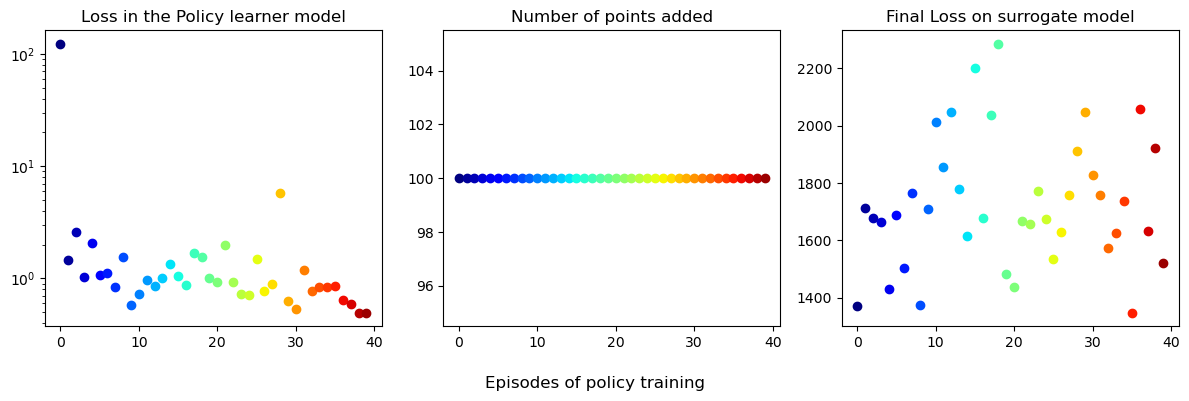

In [15]:
fig, ax = plt.subplots(1,3,tight_layout=True,figsize=(12,4))
l_old = 0
for i in range(model1.current_episode):
    ax[0].plot(i,model1.loss_curve[i][-1],'o',label='Episode %i'%i,c=plt.cm.jet(i/model1.current_episode))
#ax[0].legend(loc=0)
ax[0].set_yscale('log')

for i in range(model1.current_episode):
    ax[1].plot(i,len(aprox_perf[i]),'o',c=plt.cm.jet(i/model1.current_episode))

for i in range(model1.current_episode):
    ax[2].plot(i,aprox_perf[i][-1],'o',c=plt.cm.jet(i/model1.current_episode))

ax[0].set_title('Loss in the Policy learner model')
ax[1].set_title("Loss in the Model M")
ax[1].set_title("Number of points added")
ax[2].set_title('Final Loss on surrogate model')
fig.supxlabel('Episodes of policy training')

In [21]:
for seed in tqdm(range(40),desc='Episode'):
    aprox_perf.append([])
    randomizer = np.random
    indices = list(range(NUMBER_SAMPLES-200))
    randomizer.shuffle(indices)
    x_init, y_init = x_o.copy(), y_o.copy() #tf.cast(X_train[indices[:100]],dtype=tf.float32), tf.cast(y_train[indices[:100]],dtype=tf.float32)
    x_cand, y_cand = x_candidates[indices], y_candidates[indices] #tf.cast(X_train[indices[200:]],dtype=tf.float32), tf.cast(y_train[indices[200:]],dtype=tf.float32)
    initial_model = RandomForestRegressor(100, n_jobs=-2,random_state=158)
    initial_model.fit(x_init,y_init)
    usd = 0 
    error_prev = mean_squared_error(y_held,initial_model.predict(x_held))
    for i in tqdm(range(200),desc='State Looping'):
        s_i = state(initial_model,x_cand[i],x_init,y_init)
        a_i = tf.argmax(tf.transpose(model1.compute_qvalue(s_i)))
        if(a_i==1):
            x_init = np.append(x_init,[x_cand[i]],0)
            y_init = np.append(y_init,[y_cand[i]],0)
            usd += 1
            initial_model.fit(x_init,y_init)
            aprox_perf[-1].append(mean_squared_error(y_held,initial_model.predict(x_held)))
        error_current = mean_squared_error(y_held,initial_model.predict(x_held))
        reward = error_prev-error_current
        error_prev = error_current
        if(usd==BUDGET or i==199):
            model1.add_to_memory(s_i,a_i,reward,None)
            break
        else:
            s_ip1 = state(initial_model,x_cand[i+1],x_init,y_init)
            model1.add_to_memory(s_i,a_i,reward,s_ip1)

        if(i>BATCH_SIZE):
            cur_mem = model1.get_current_memory()
            indices = randomizer.randint(len(cur_mem)-1,size=BATCH_SIZE)
            batch_sf = tf.reshape(tf.cast(list( cur_mem[i][3] for i in indices),dtype=tf.float32),[BATCH_SIZE,12])
            batch_r = tf.reshape(tf.cast(list( cur_mem[i][2] for i in indices),dtype=tf.float32),[BATCH_SIZE,1])
            batch_si = tf.reshape(tf.cast(list( cur_mem[i][0] for i in indices),dtype=tf.float32),[BATCH_SIZE,12])
            batch_ai = tf.reshape(tf.cast(list( cur_mem[i][1] for i in indices),dtype=tf.float32),[BATCH_SIZE,1])
            ys = model1.y_value(batch_sf,batch_r )
            model1.Training_network(ys,batch_ai,batch_si)
    model1.finish_episode()

Episode:   0%|          | 0/40 [00:00<?, ?it/s]

State Looping:   0%|          | 0/200 [00:00<?, ?it/s]

State Looping:   0%|          | 0/200 [00:00<?, ?it/s]

State Looping:   0%|          | 0/200 [00:00<?, ?it/s]

State Looping:   0%|          | 0/200 [00:00<?, ?it/s]

State Looping:   0%|          | 0/200 [00:00<?, ?it/s]

State Looping:   0%|          | 0/200 [00:00<?, ?it/s]

State Looping:   0%|          | 0/200 [00:00<?, ?it/s]

State Looping:   0%|          | 0/200 [00:00<?, ?it/s]

State Looping:   0%|          | 0/200 [00:00<?, ?it/s]

State Looping:   0%|          | 0/200 [00:00<?, ?it/s]

State Looping:   0%|          | 0/200 [00:00<?, ?it/s]

State Looping:   0%|          | 0/200 [00:00<?, ?it/s]

State Looping:   0%|          | 0/200 [00:00<?, ?it/s]

State Looping:   0%|          | 0/200 [00:00<?, ?it/s]

State Looping:   0%|          | 0/200 [00:00<?, ?it/s]

State Looping:   0%|          | 0/200 [00:00<?, ?it/s]

KeyboardInterrupt: 

Text(0.5, 0, 'Number of candidate points added')

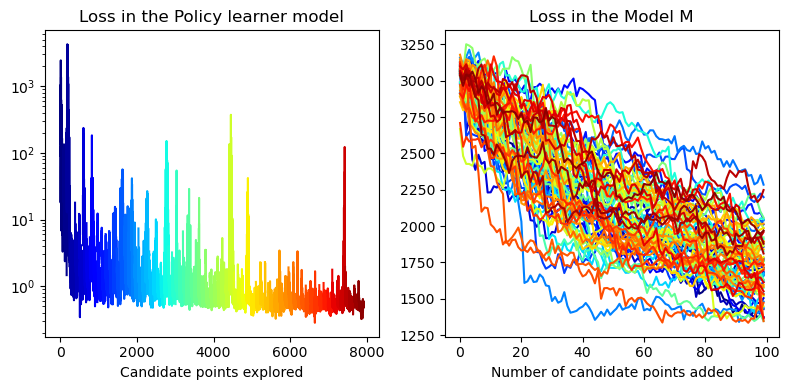

In [22]:
fig, ax = plt.subplots(1,2,tight_layout=True,figsize=(8,4))
l_old = 0
for i in range(len(model1.loss_curve)-1):
    ll = model1.loss_curve[i]
    ax[0].plot(range(l_old,l_old+len(ll)),ll,'-',label='Episode %i'%i,c=plt.cm.jet(i/model1.current_episode))
    l_old += len(ll) 
#ax[0].legend(loc=0)
ax[0].set_yscale('log')

for i in range(model1.current_episode):
    ax[1].plot(aprox_perf[i],c=plt.cm.jet(i/model1.current_episode))

ax[0].set_title('Loss in the Policy learner model')
ax[0].set_xlabel("Candidate points explored")
ax[1].set_title("Loss in the Model M")
ax[1].set_xlabel("Number of candidate points added")

Text(0.5, 0.01, 'Episodes of policy training')

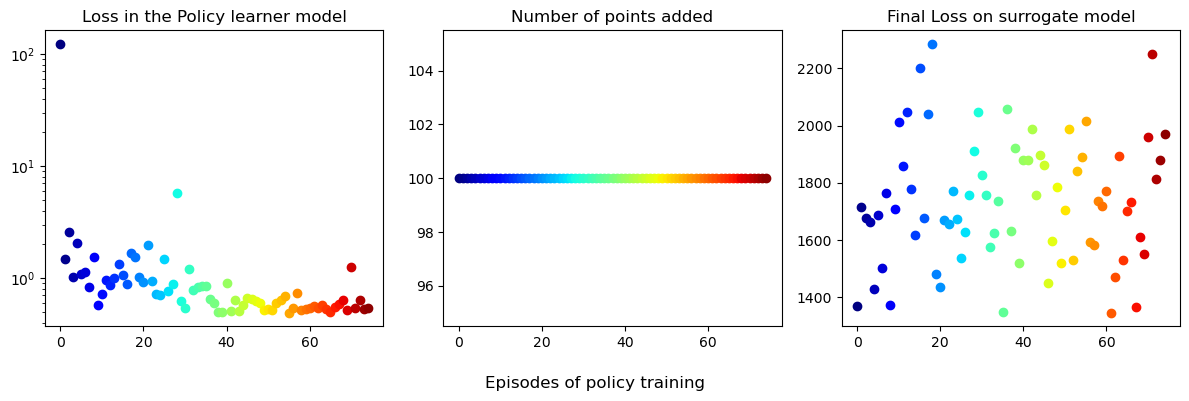

In [23]:
fig, ax = plt.subplots(1,3,tight_layout=True,figsize=(12,4))
l_old = 0
for i in range(model1.current_episode):
    ax[0].plot(i,model1.loss_curve[i][-1],'o',label='Episode %i'%i,c=plt.cm.jet(i/model1.current_episode))
#ax[0].legend(loc=0)
ax[0].set_yscale('log')

for i in range(model1.current_episode):
    ax[1].plot(i,len(aprox_perf[i]),'o',c=plt.cm.jet(i/model1.current_episode))

for i in range(model1.current_episode):
    ax[2].plot(i,aprox_perf[i][-1],'o',c=plt.cm.jet(i/model1.current_episode))

ax[0].set_title('Loss in the Policy learner model')
ax[1].set_title("Loss in the Model M")
ax[1].set_title("Number of points added")
ax[2].set_title('Final Loss on surrogate model')
fig.supxlabel('Episodes of policy training')